In [1]:
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model, svm
import statsmodels.api as sm
import numpy as np
import seaborn as sb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.under_sampling import NearMiss
import ipywidgets as widgets
from scipy.special import expit

In [63]:
%matplotlib inline

In [66]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<div align=center>
<h1>INFO257 - Inteligencia Artificial</h1>
<h2>Entrenamiento de modelos de clasificación supervisada para clasificación de cuerpos celestes basado en observaciones de Sloan Digital Sky Survey</h2>
<h6>Eduardo Vera Barrientos</h6>
</div>

En este notebook trataremos de clasificar observaciones de cuerpos celestes en tres categorías: Galaxias, Estrellas y Quasar usando métodos de <i>Machine Learning</i>, específicamente Regresión Logística, Árboles de desicion y Random Forest.
Usaremos datos provenientes del <b>Sloan Digital Sky Survey</b>, específicamente el <i>Data Release 14</i>.

<h2>Dataset Analysis</h2>

### Descripción de los datos
- Datos de posicionamiento
    - objid: Object ID
    - ra: Right Ascension
    - dec: Declination

- Magnitudes de longitud de onda {u,g,r,i,z}
    - u: Ultraviolet
    - g: Green
    - r: Red
    - i: Infrared - 7600 Â
    - z: Infrared - 9100 Â

- Observación Óptica {redshift,plate,mjd,fiberid}
    - redshift: Final redshift, efecto de "correr al rojo" producido por el efecto Doppler
    - plate: SDSS plug plate used
    - mjd: Modified Julian Date
    - fiberid: Fiber number

Las siguientes características no se usaran ya que no describen alguna propiedad de los cuerpos celestes observados

- objid
- ra
- dec
- run
- rerun
- camcol
- field
- specobjid
- plate
- mjd
- fiberid

### Vista previa del dataset

In [3]:
df = pd.read_csv("SDSS-DR14.csv")
display(df)

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.237650e+18,131.316413,51.539547,18.81777,17.47053,16.91508,16.68305,16.50570,1345,301,3,161,5.033450e+17,GALAXY,0.027583,447,51877,246
9996,1.237650e+18,131.306083,51.671341,18.27255,17.43849,17.07692,16.71661,16.69897,1345,301,3,162,5.033400e+17,GALAXY,0.117772,447,51877,228
9997,1.237650e+18,131.552562,51.666986,18.75818,17.77784,17.51872,17.43302,17.42048,1345,301,3,162,8.222620e+18,STAR,-0.000402,7303,57013,622
9998,1.237650e+18,131.477151,51.753068,18.88287,17.91068,17.53152,17.36284,17.13988,1345,301,3,163,5.033400e+17,GALAXY,0.014019,447,51877,229


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


Ya que el dataset no presenta valores nulos en ninguna de sus columnas y no presenta datos categóricos aparte de la clase, no es necesario hacer un ajuste de los datos.

In [5]:
#Drop unused columns
df.drop(columns = ['objid','ra','dec','run','rerun','camcol','field','specobjid','plate','mjd','fiberid'], inplace=True)

### Exploración de los datos

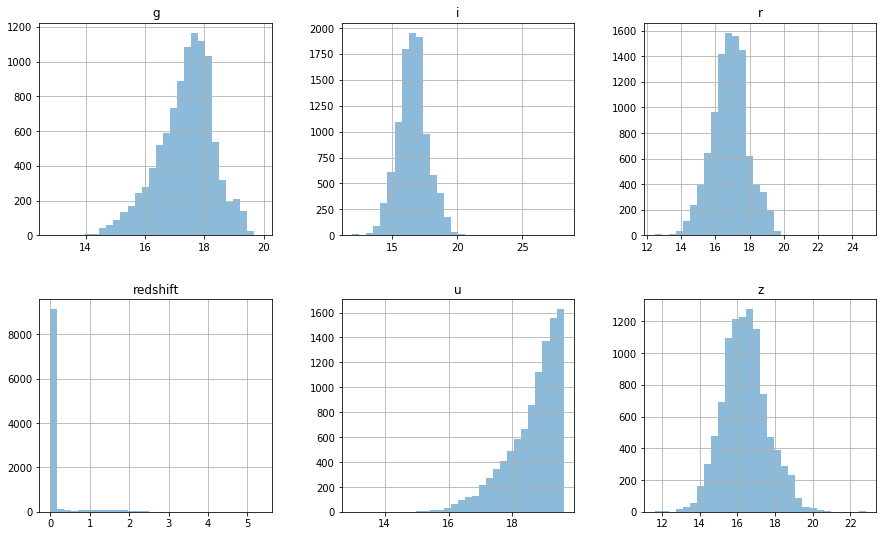

In [6]:
#Distribution Analysis
fig,ax = plt.subplots(nrows=2,ncols=3, figsize = (15,9))
df.hist(bins = 30, alpha = 0.5, ax=ax)
plt.show()

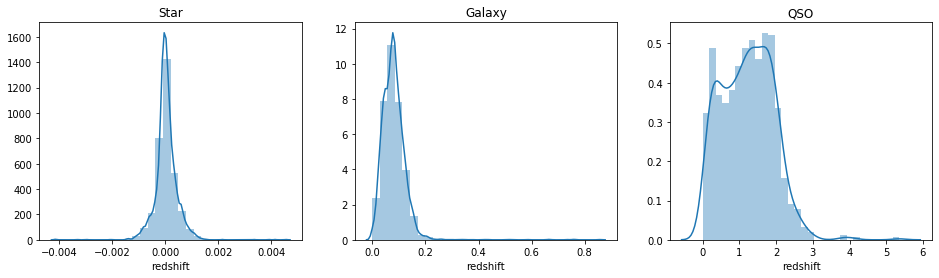

In [7]:
#Redshift distribution by class
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))

ax = sb.distplot(df[df['class']=='STAR'].redshift, bins = 30, ax = axes[0])
ax.set_title('Star')
ax = sb.distplot(df[df['class']=='GALAXY'].redshift, bins = 30, ax = axes[1])
ax.set_title('Galaxy')
ax = sb.distplot(df[df['class']=='QSO'].redshift, bins = 30, ax = axes[2])
ax = ax.set_title('QSO')
plt.show()

#### Separacion de los datos

In [8]:
Y = df['class']

In [9]:
X = df.drop(columns = ['class'])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .4, random_state=45)

In [11]:
print('Total train samples by class \n', y_train.value_counts())
print('Training Data Ratios: \n', y_train.value_counts()/y_train.value_counts().min())

Total train samples by class 
 GALAXY    2969
STAR      2499
QSO        532
Name: class, dtype: int64
Training Data Ratios: 
 GALAXY    5.580827
STAR      4.697368
QSO       1.000000
Name: class, dtype: float64


Matriz de correlación


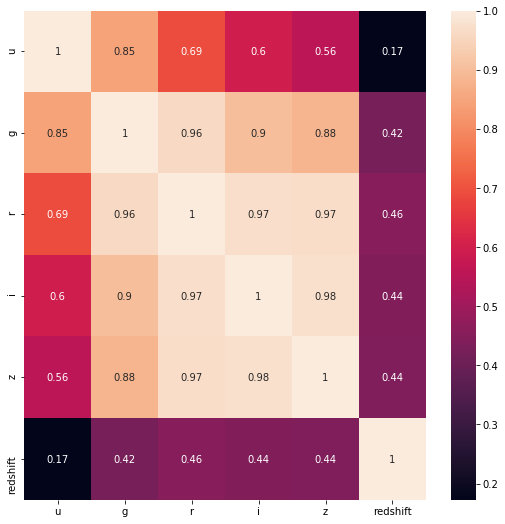

In [12]:
print("Matriz de correlación")
f,ax = plt.subplots(figsize=(9, 9))
sb.heatmap(X_train.corr(), annot = True, ax=ax)
plt.show()

### Balancear el dataset de entrenamiento
Para balancear el dataset se usará el método de Synthetic Minority Oversampling Technique (SMOTE), el cual es una tecnica de oversampling que crea datos sintéticos de la clase minoritaria

In [13]:
# Resampling data using SMOTE
resample = SMOTE(sampling_strategy='minority', n_jobs = -1)
# transform the dataset
resampled_trainX, resampled_trainY = resample.fit_resample(X_train, y_train)
resampled_train = pd.concat([pd.DataFrame(resampled_trainY), pd.DataFrame(resampled_trainX)], axis=1)

In [14]:
resampled_train.groupby('class').count()

,u,g,r,i,z,redshift
class,,,,,,
GALAXY,2969,2969,2969,2969,2969,2969
QSO,2969,2969,2969,2969,2969,2969
STAR,2499,2499,2499,2499,2499,2499


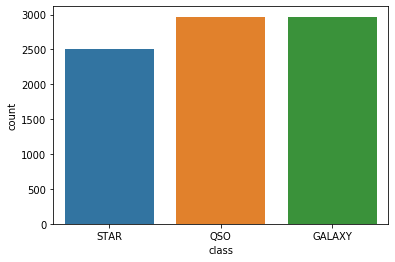

In [15]:
sb.countplot(x = 'class', data = resampled_train)
plt.show()

Matriz de correlación despues del balance


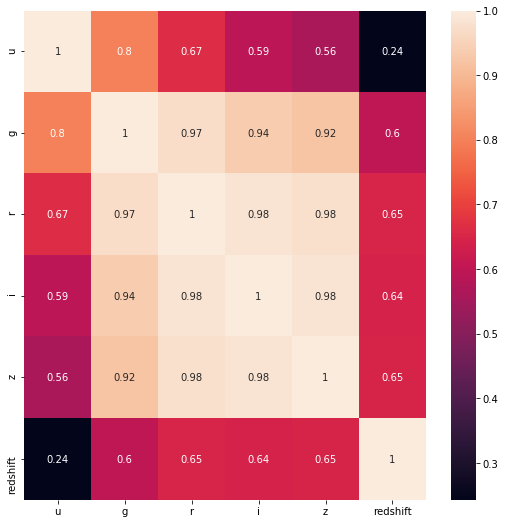

In [73]:
print("Matriz de correlación despues del balance")
f,ax = plt.subplots(figsize=(9, 9))
sb.heatmap(resampled_trainX.corr(), annot=True, ax=ax)
plt.show()

# Aprendizaje de modelos

### Logistic Regression

In [17]:
#Aprendizaje
logreg = LogisticRegression(max_iter = 10000)
logreg.fit(resampled_trainX, resampled_trainY)

LogisticRegression(max_iter=10000)

In [18]:
#Predicciones
y_pred = logreg.predict(X_test)

In [19]:
#Evaluación del rendimiento del clasificador
logreg_matrix = confusion_matrix(y_test, y_pred)

In [20]:
logreg_report = classification_report(y_test, y_pred)

### Decision tree

In [21]:
from sklearn import tree
#Entrenamiento
dtree = tree.DecisionTreeClassifier()
dtree.fit(resampled_trainX,resampled_trainY)

DecisionTreeClassifier()

In [22]:
#Predicciones
y_pred = dtree.predict(X_test)
#Evaluación del rendimiento del clasificador
#from sklearn.metrics import confusion_matrix
tree_matrix = confusion_matrix(y_test, y_pred)
#Print de la matriz de confusión
tree_report = classification_report(y_test, y_pred)

### Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=15)
#Profiling
forest.fit(resampled_trainX,resampled_trainY) 

RandomForestClassifier(n_estimators=15)

In [24]:
#Predicciones
y_pred = forest.predict(X_test)
#Evaluación del rendimiento del clasificador
forest_matrix = confusion_matrix(y_test, y_pred)
#Print de la matriz de confusión
forest_report = classification_report(y_test, y_pred)

# Model Evaluation

### Logistic Regression

In [25]:
print("Logistic Regression Report: \n" + logreg_report)

Logistic Regression Report: 
              precision    recall  f1-score   support

      GALAXY       0.98      0.94      0.96      2029
         QSO       0.96      0.97      0.96       318
        STAR       0.94      0.98      0.96      1653

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



Como se puede apreciar en el reporte, este modelo se ajusta bien a los datos de entrenamiento lo que resulta en una muy buena predicción para la clasificación de clases de cuerpos celestes con un 96% de exactitud.

In [26]:
print('Coeficientes de características')
cols = X_train.columns
for i in logreg.classes_:
    row = np.abs(logreg.coef_[np.where(logreg.classes_ == i)[0][0]])
    maxi = np.max(row)
    print(i,maxi,cols[np.where(row == maxi)[0][0]])

Coeficientes de características
GALAXY 4.836807423103376 redshift
QSO 11.824849929319823 redshift
STAR 16.661657352446504 redshift


LogisticRegression calcula distintos coeficientes para cada caracteristica para cada clase. La caracteristica más importante (con mas peso) tanto para la clase GALAXY como para QSO y STAR es <i>redshift</i>

### Decision Tree

In [27]:
print("Decision Tree Report: \n" + tree_report)

Decision Tree Report: 
              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.98      2029
         QSO       0.87      0.93      0.90       318
        STAR       1.00      1.00      1.00      1653

    accuracy                           0.98      4000
   macro avg       0.95      0.97      0.96      4000
weighted avg       0.98      0.98      0.98      4000



Según el reporte, este modelo es capaz de identificar a la perfección las estrellas del dataset. Para el resto de las clases también se comporta bastante bien con valores de precision y recall cercanos a 1.0

In [28]:
print('Coeficiente de Características\n')
for x in range(dtree.feature_importances_.size):
    print(X_train.columns[x],dtree.feature_importances_[x])

Coeficiente de Características

u 0.018416579585738498
g 0.004990661779021081
r 0.012582525397475057
i 0.007957429227499771
z 0.005643046975244311
redshift 0.9504097570350213


La característica más importante para este modelo es <i>redshift</i> con un peso de 0.94

### Random Forest

In [29]:
print("Random Forest Report: \n" + forest_report)

Random Forest Report: 
              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      2029
         QSO       0.94      0.95      0.95       318
        STAR       0.99      1.00      1.00      1653

    accuracy                           0.99      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.99      0.99      0.99      4000



Para clasificar si un cuerpo celeste es una estrella o una galaxia, nuestro modelo de Random Forest es practicamente perfecto, sin embargo, para la clase QSO su resultado es más que aceptable, alcanzando un F-measure de 0.95

In [30]:
print('Coeficiente de características')
for x in range(forest.feature_importances_.size):
    print(X_train.columns[x],forest.feature_importances_[x])

Coeficiente de características
u 0.05520160392268252
g 0.04900173088925568
r 0.12787442678926417
i 0.10421352462995097
z 0.07737976484358187
redshift 0.5863289489252649


La característica más importante para éste modelo es <i>redshift</i>

## Comparativa

In [31]:
print("Logistic Regression Report: \n" + logreg_report)
print("Decision Tree Report: \n" + tree_report)
print("Random Forest Report: \n" + forest_report)

Logistic Regression Report: 
              precision    recall  f1-score   support

      GALAXY       0.98      0.94      0.96      2029
         QSO       0.96      0.97      0.96       318
        STAR       0.94      0.98      0.96      1653

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000

Decision Tree Report: 
              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.98      2029
         QSO       0.87      0.93      0.90       318
        STAR       1.00      1.00      1.00      1653

    accuracy                           0.98      4000
   macro avg       0.95      0.97      0.96      4000
weighted avg       0.98      0.98      0.98      4000

Random Forest Report: 
              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      2029
         QSO       0.94      0.95      0.95       318


Haciendo una comparación entre los tres modelos entrenados podemos notar lo siguiente.
- Precision: los tres modelos presentan valores cercanos a 1 para las clases GALAXY y STAR, la precision de QSO es la que presenta mayor variabilidad (entre .87 y .95)
- Recall: El valor de recall más alto lo obtiene Decision tree y Random Forest para la clase STAR con 1.0, el menor valor lo obtiene Decision Tree para la clase QSO
- F1-score: Es una medida de la exactitud del test que considera el Precision y Recall. Los tres modelos obtienen una alta puntuación, siendo el valor más bajo 0.90, lo que quiere decir que los modelos son buenos para hacer una clasificación del dataset.
- accuracy: Esta métrica nos dice el numero correcto de predicciones en comparación con el total de predicciones, en ese sentido, los modelos usados son capaces de predecir con una exactitud superior al 96%, por lo que cualquiera de los tres modelos es apto para seleccionar como clasificador.

### Ventajas y desventajas
En la siguiente tabla se listarán las ventajas y desventajas encontradas correspondientes a cada modelo de clasificación supervisada usado

|Models|Linear Regression|Decision Tree|Random Forest|
|---|---|---|---|
|Ventajas|Simple y efectivo<br/>No necesita escalamiento<br/>Puede trabajar tanto en clasificación binaria o multiclase<br/>Trabaja bien con datos dispersos o densos|No es necesario el escalado o normalizado de los datos<br/> Puede trabajar con valores faltantes y valores categoricos<br/>Fácil de entender<br/>|Error Reducido<br/> Buena performance en dataset desbalanceados<br/>No tiene problemas de sobreajuste<br/>Tiene ademas las ventajas de usar Decision Tree|
|Desventajas|Performance reducida con datos no lineales o características altamente correlacionadas<br/>Es facilmente sobrepasado por otros algoritmos<br/>Es preferible usarlo en clasificacion binaria|Fácilmente puede sobreajustarse<br/>Sensible a los datos<br/>Es preferible balancear los datos para evitar bias|Necesita que los arboles que se crean tengan poca correlación<br/>Difícil conocer lo que está haciendo<br/>|


### Análisis de características
Analizaremos la relevancia de las características usadas para cada modelo

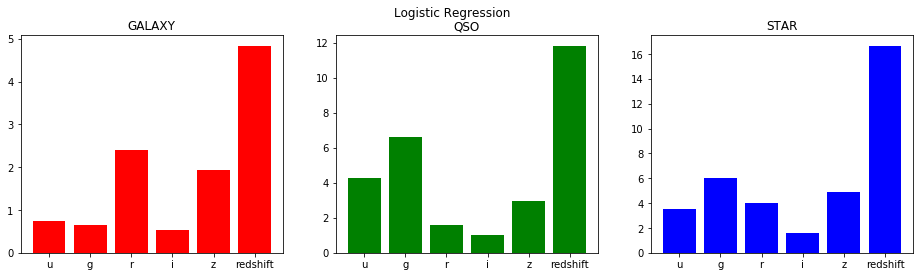

In [88]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))

color=['red','green','blue']

for i in range(3):
    axes[i].bar(cols.array, np.abs(logreg.coef_[i]), color=color[i])
    axes[i].set_title(logreg.classes_[i])

fig.suptitle("Logistic Regression")
plt.show()

Para el modelo de Regresión logística, la característica que más influencia tiene para las tres clases es *redshift* por un margen considerable.

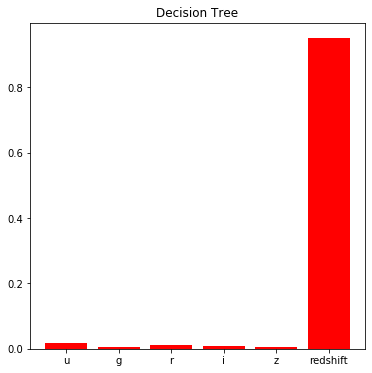

In [90]:
fig,ax = plt.subplots(figsize=(6,6))

ax.bar(cols,dtree.feature_importances_, color='red')
ax.set_title("Decision Tree")

plt.show()

En el modelo de Árbol de decisión nuevamente tenemos a *redshift* como característica más relevante, el aporte de el resto de características al modelo es tan bajo que podrían descartarse para este modelo

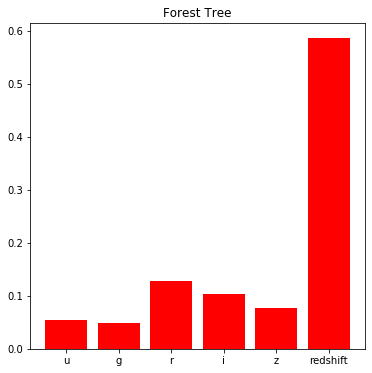

In [86]:
fig,ax = plt.subplots(figsize=(6,6))

ax.bar(cols,forest.feature_importances_, color='red')
ax.set_title("Forest Tree")

plt.show()

En *Forest Tree* la característica que más afecta la clasificación es ***redshift*** como se puede apreciar en el gráfico, seguido de ***r*** e ***i***

Para los tres modelos de clasificación la característica que más influyente es ***redshift*** por un margen considerable, esto puede deberse a que, de acuerdo a la <a href='https://www.sdss.org/dr14/algorithms/redshifts/' >SDSS</a>, redshift es calculado a partir de un análisis de componentes principales (PCA) de redshifts de referencia calculados a partir de las longitudes de onda de un objeto observado.
Si se usa Decision Tree es posible utilizar sólo redshift y eliminar las características restantes para evaluar nuestro dataset.